In [21]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,NMF
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from gensim.corpora import Dictionary  # Import for NMF coherence
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from textblob import TextBlob


In [22]:
data = pd.read_csv('casts.csv')

In [23]:
data['text'] = data['text'].astype(str)

# Preprocessing the text data
def preprocess_text(text):
  # Converting to lowercase
  text = text.lower()
  # Removing special characters and numbers
  text = re.sub(r"[^a-zA-Z\s]", "", text)
  # Tokenizing the text
  tokens = word_tokenize(text)
  # Removing stop words
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  # Stemming (optional)
  stemmer = PorterStemmer()
  tokens = [stemmer.stem(word) for word in tokens]
  # Joining tokens back into a string
  return " ".join(tokens)

data['cleaned_text'] = data['text'].apply(preprocess_text)

# Display the first few rows of the cleaned text
print(data['cleaned_text'].head())


0    even market go stay social time social summer ...
1    gm fren time updat phaver appplay store fresh ...
2    simpl guid xyz node whitelistnnbin incubationn...
3                                      wait social tge
4                                             red morn
Name: cleaned_text, dtype: object


### Exploratory Data Analysis

In [24]:
# Calculating average text length
avg_text_length = data['cleaned_text'].apply(len).mean()
print("Average text length:", avg_text_length)

Average text length: 86.593


#### Most frequent words

In [25]:
from collections import Counter
all_words = ' '.join(data['cleaned_text']).split()
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)
print("Most common words:", most_common_words)

Most common words: [('v', 100), ('c', 95), ('n', 93), ('use', 68), ('day', 64), ('social', 63), ('mask', 63), ('gm', 62), ('nnhttpscodelqotpsitedegenmaskjpg', 62), ('ngi', 59), ('phaver', 57), ('tip', 56), ('check', 55), ('u', 54), ('free', 54), ('mi', 52), ('good', 49), ('give', 49), ('th', 49), ('stat', 49)]


#### User activity analysis

In [26]:
user_activity = data.groupby('fid')['cleaned_text'].count().reset_index(name='post_count')
print(user_activity.head())

   fid  post_count
0    2           7
1    3          16
2    8           5
3   12           9
4   25           1


In [27]:
user_activity = data.groupby('fid')['cleaned_text'].count().reset_index(name='post_count')

# Calculating average post length per user
user_avg_length = data.groupby('fid')['cleaned_text'].apply(len).reset_index(name='avg_post_length')

# Merging user activity and average post length
user_stats = user_activity.merge(user_avg_length, on='fid')

# User activity analysis
user_activity = data.groupby('fid')['cleaned_text'].agg(
    post_count='count',
    total_words=lambda x: sum(len(text.split()) for text in x),
    unique_words=lambda x: len(set(' '.join(x).split()))
).reset_index()

print(user_activity.head())

   fid  post_count  total_words  unique_words
0    2           7           72            62
1    3          16          204           162
2    8           5           58            46
3   12           9          253           185
4   25           1           20            13


#### Identifying Influential Users

In [28]:
# Calculating a combined score based on multiple metrics (adjust weights as needed)

# Influence Score = 1 x Post count + 0.5 x Total words + 0.2 x Unique words
user_activity['influence_score'] = user_activity['post_count'] * 1 + user_activity['total_words'] * 0.5 + user_activity['unique_words'] * 0.2

# Rank users by influence score
influential_users = user_activity.sort_values(by='influence_score', ascending=False)
print(influential_users.head())

        fid  post_count  total_words  unique_words  influence_score
379  535436          35          586           385            405.0
85   247746          19          502           321            334.2
11      239          11          333           277            232.9
56    15983          14          339           214            226.3
117  308322           6          336           233            220.6


#### Analyzing User Engagement

In [29]:
# Assuming you have columns for reactions, comments, and shares
data['total_engagement'] = data['reaction_count'] + data['reply_count']

user_engagement = data.groupby('fid')['total_engagement'].sum().reset_index(name='total_engagement')

# Merge engagement data with user activity
user_stats = user_activity.merge(user_engagement, on='fid')
print(user_stats.head())

   fid  post_count  total_words  unique_words  influence_score  \
0    2           7           72            62             55.4   
1    3          16          204           162            150.4   
2    8           5           58            46             43.2   
3   12           9          253           185            172.5   
4   25           1           20            13             13.6   

   total_engagement  
0              6528  
1             13432  
2              2874  
3              6538  
4              1408  


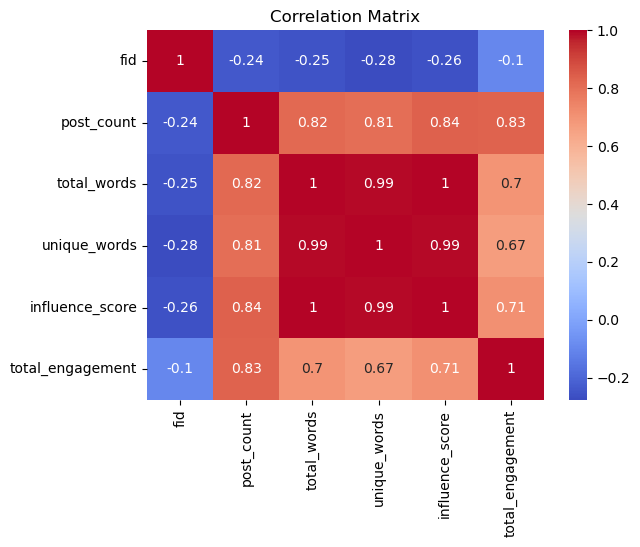

In [30]:
# Analyzing User Behavior
import seaborn as sns

# Calculate correlations
correlations = user_stats.corr()

# Visualize correlation matrix
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Visualizing User Activity

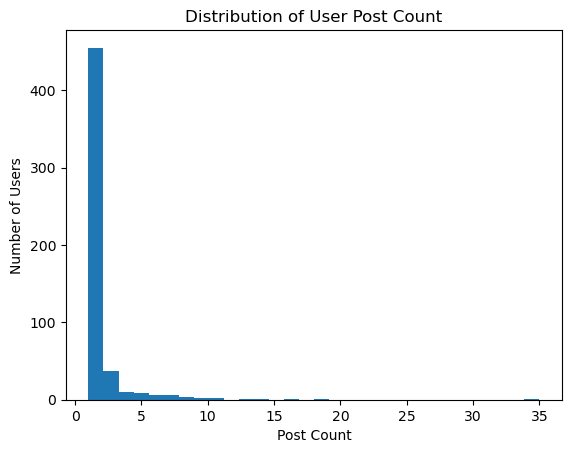

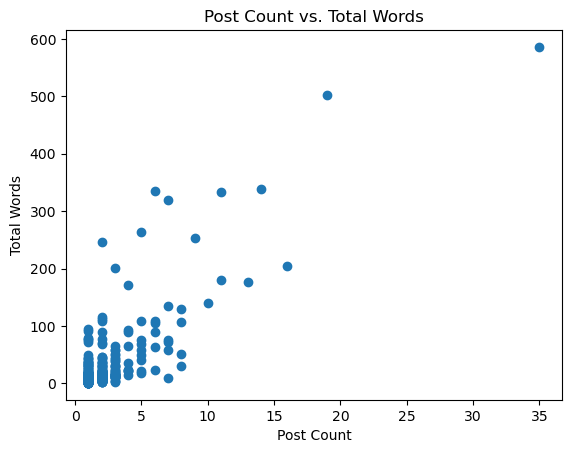

In [31]:
# Histogram of post count
plt.hist(user_activity['post_count'], bins=30)
plt.xlabel('Post Count')
plt.ylabel('Number of Users')
plt.title('Distribution of User Post Count')
plt.show()

# Scatter plot of post count vs. total words
plt.scatter(user_activity['post_count'], user_activity['total_words'])
plt.xlabel('Post Count')
plt.ylabel('Total Words')
plt.title('Post Count vs. Total Words')
plt.show()

### <font color='Blue'>Topic Modeling </font>

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

doc_term_matrix = vectorizer.fit_transform(data['cleaned_text'])


#### Applying LDA

In [33]:

from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components as needed
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [34]:
# Printing topics

def print_topics(model, vectorizer, n_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic #%d:" % idx)
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-n_top_words- 1:-1]])
    print()
    
print_topics(lda_model, vectorizer, 10)

Topic #0:
[('mask', 32.59978731738503), ('good', 12.805328131055058), ('morn', 11.19061196598602), ('day', 7.27336959057892), ('love', 6.675809171904125), ('httpswwwearnalliancecomreferralscnjfutmcampaignreferralutmmediumcopyutmsourcereferralpag', 6.1998655154484075), ('tra', 6.124601605612857), ('hello', 4.81724529031062), ('beauti', 4.6956159728449425), ('nncheck', 4.670702991514245)]
Topic #1:
[('nan', 31.28835023141751), ('gm', 21.488077169504397), ('social', 8.559955345831392), ('degen', 7.788216082588483), ('join', 7.5226306177112106), ('let', 7.25535153561958), ('day', 6.6555598075528035), ('phaver', 6.565048756137032), ('project', 5.895450996204592), ('guy', 5.717060762907563)]
Topic #2:
[('nnhttpscodelqotpsitedegenmaskjpg', 5.714626219399766), ('today', 4.731771272588733), ('moment', 4.535756255878818), ('amaz', 3.4657544277036605), ('alway', 3.1271188629400557), ('bro', 3.0498708405782726), ('cung', 2.9695501489363383), ('base', 2.9628328523578937), ('vi', 2.942474283273239),

### Sentiment Analysis

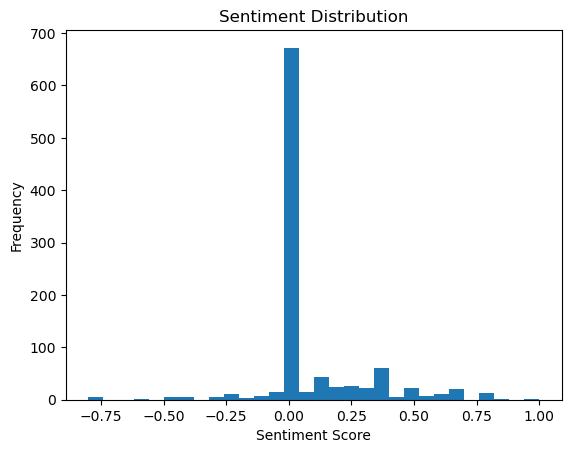

In [35]:


def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

data['sentiment'] = data['cleaned_text'].apply(get_sentiment)

plt.hist(data['sentiment'], bins=30)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()


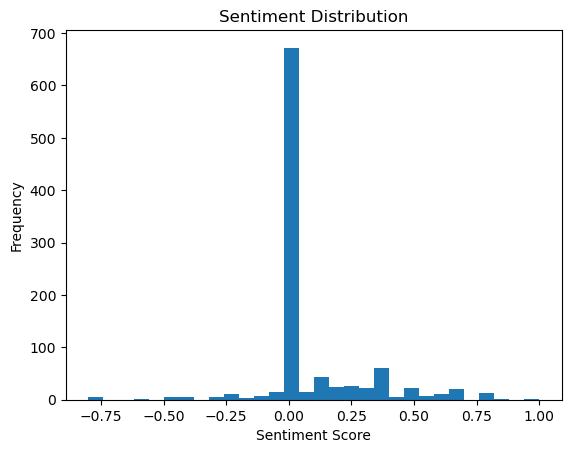

In [36]:
from textblob import TextBlob

# Assuming 'cleaned_text' column contains preprocessed text

def get_sentiment(text):
  try:
    blob = TextBlob(text)
    return blob.sentiment.polarity
  except Exception as e:
    print(f"Error processing text: {e}")
    return np.nan  # Handle errors gracefully

data['sentiment'] = data['cleaned_text'].apply(get_sentiment)

# Analyze sentiment distribution
import matplotlib.pyplot as plt

plt.hist(data['sentiment'], bins=30)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()


#### User Segmentation

In [37]:
# Get topic assignments for each document
topic_assignments = lda_model.transform(doc_term_matrix).argmax(axis=1)

# Create a 'topic' column in the DataFrame
data['topic'] = topic_assignments

def define_user_segments(post_count):
    if post_count <= 10:
        return 'Low Poster'
    elif post_count <= 50:
        return 'Medium Poster'
    else:
        return 'High Poster'

data['user_segment'] = data.groupby('fid')['cleaned_text'].transform('count').apply(define_user_segments)

In [38]:
# Calculate average sentiment for each user segment and topic
sentiment_by_segment_topic = data.groupby(['user_segment', 'topic'])['sentiment'].mean().reset_index()
sentiment_by_segment_topic

,user_segment,topic,sentiment
0,Low Poster,0,0.083758
1,Low Poster,1,0.120464
2,Low Poster,2,0.063187
3,Low Poster,3,0.141345
4,Low Poster,4,0.029541
5,Medium Poster,0,0.205675
6,Medium Poster,1,0.063882
7,Medium Poster,2,-0.137750
8,Medium Poster,3,0.109542
9,Medium Poster,4,0.215000


#### Heatmap to visualize sentiment across user segments and topics

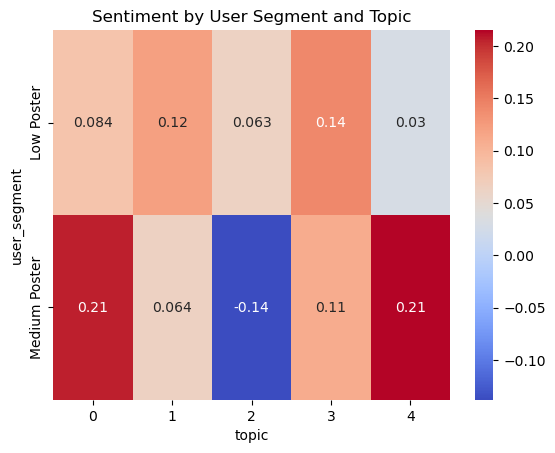

In [39]:

# Calculate average sentiment per user segment and topic
sentiment_by_segment_topic = data.groupby(['user_segment', 'topic'])['sentiment'].mean().reset_index()

# Create a pivot table
sentiment_pivot = sentiment_by_segment_topic.pivot_table(index='user_segment', columns='topic', values='sentiment')

# Visualize sentiment heatmap
sns.heatmap(sentiment_pivot, annot=True, cmap='coolwarm')
plt.title('Sentiment by User Segment and Topic')
plt.show()